# Hourly Bike Rental Prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
sns.set_style('ticks')

## Looking At Our Data

In [2]:
df_hour = pd.read_csv('train.csv')
df_hour.shape

(10886, 12)

In [3]:
df_hour.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### Checking if we have any missing values

No white areas on the heatmap. There seems to be no missing values

<AxesSubplot:>

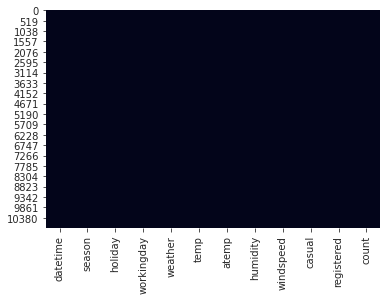

In [5]:
sns.heatmap(df_hour.isnull(), cbar=False)

Also we can check for missing values by this method

In [6]:
df_hour.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [7]:
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'registered', 'casual', 'count']
categorical_features = ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather']

### Feature Tranformations and Standardizations/Normalizations

In [8]:
df_hour['datetime'] = pd.to_datetime(df_hour['datetime'])

Let's extract hour, month, year and day information from the datetime column

In [9]:
df_hour['hour'] = df_hour['datetime'].dt.hour
df_hour['hour'].value_counts()

23    456
20    456
16    456
17    456
18    456
15    456
12    456
19    456
13    456
21    456
14    456
22    456
6     455
11    455
10    455
9     455
7     455
8     455
0     455
1     454
5     452
2     448
4     442
3     433
Name: hour, dtype: int64

In [10]:
df_hour['month'] = df_hour['datetime'].dt.month
df_hour['month'].value_counts()

7     912
6     912
5     912
12    912
8     912
11    911
10    911
4     909
9     909
3     901
2     901
1     884
Name: month, dtype: int64

In [11]:
df_hour['year'] = df_hour['datetime'].dt.year
df_hour['year'].value_counts()

2012    5464
2011    5422
Name: year, dtype: int64

In [12]:
df_hour['weekday'] = df_hour['datetime'].dt.weekday
df_hour['weekday'].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: weekday, dtype: int64

Now, encoding the year column

In [13]:
encoder = LabelEncoder()
df_hour['year'] = encoder.fit_transform(df_hour['year'])

### Generating New Features

Our date and time features are label encoded. For example, hour is represented as a number between 0 and 23. This might not make sense because hour is not linear, but rather, it's cyclic. So, generating a cyclic representation of this feature certainly will improve our model. And that's true for month and season too.

So, how do we do that transformation? We need some kind of a cyclic function to do that. These might be sine and cosine functions. Transformation formula that we will use is this: 

$ X = \{x_i\}^{N}_{x=1} $.

$y = \max (X)$

Let $z$ be the cylical transformation for $x$. Then:
$$ z_i = \sin\left(\frac{2x_i}{y}\right)$$

Note: We don't need these transformation when using tree based methods because they handle these very features without problem.

In [14]:
hour_cyclic = df_hour['hour'].apply(lambda x: np.sin(2*x/23 * np.pi))
month_cyclic = df_hour['month'].apply(lambda x: np.sin(2*x/12 * np.pi))
season_cyclic = df_hour['season'].apply(lambda x: np.sin(2*x/4 * np.pi))
day_cyclic = df_hour['weekday'].apply(lambda x: np.sin(2*x/7 * np.pi))
df_hour = df_hour.assign(hour_cyclic=hour_cyclic, month_cyclic=month_cyclic, season_cyclic=season_cyclic, day_cyclic=day_cyclic)

In [15]:
df_hour

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,year,weekday,hour_cyclic,month_cyclic,season_cyclic,day_cyclic
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1,0,5,0.000000e+00,5.000000e-01,1.000000e+00,-0.974928
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,0,5,2.697968e-01,5.000000e-01,1.000000e+00,-0.974928
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,1,0,5,5.195840e-01,5.000000e-01,1.000000e+00,-0.974928
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,1,0,5,7.308360e-01,5.000000e-01,1.000000e+00,-0.974928
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,1,0,5,8.878852e-01,5.000000e-01,1.000000e+00,-0.974928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,12,1,2,-8.878852e-01,-2.449294e-16,-2.449294e-16,0.974928
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,12,1,2,-7.308360e-01,-2.449294e-16,-2.449294e-16,0.974928
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,12,1,2,-5.195840e-01,-2.449294e-16,-2.449294e-16,0.974928
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,12,1,2,-2.697968e-01,-2.449294e-16,-2.449294e-16,0.974928


### Train/Validation Split

In [16]:
df_train, df_val = train_test_split(df_hour, test_size=0.1, shuffle=False)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

#### Shuffling the train data

In [17]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [18]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'month', 'year', 'weekday', 'hour_cyclic', 'month_cyclic',
       'season_cyclic', 'day_cyclic'],
      dtype='object')

### Normalizing the Features

Finally, let's normalize our highly variant features.

In [19]:
numerics= [
        'temp', 
        'atemp', 
        'humidity', 
        'windspeed', 
        'hour_cyclic', 
        'day_cyclic', 
        'season_cyclic', 
        'month_cyclic', 
]

In [20]:
df_train[numerics].var()

temp              63.071919
atemp             74.679216
humidity         377.884639
windspeed         68.006079
hour_cyclic        0.478640
day_cyclic         0.502522
season_cyclic      0.553162
month_cyclic       0.528769
dtype: float64

In [21]:
scaler = MinMaxScaler()

In [22]:
df_train_normalized = scaler.fit_transform(df_train[numerics])
df_train_normalized = pd.DataFrame(df_train_normalized, columns=numerics).add_prefix('n_')
df_train_normalized

,n_temp,n_atemp,n_humidity,n_windspeed,n_hour_cyclic,n_day_cyclic,n_season_cyclic,n_month_cyclic
0,0.489796,0.525338,0.82,0.350888,0.364786,0.722521,0.5,0.750000
1,0.204082,0.288064,0.64,0.000000,0.816281,0.500000,1.0,0.750000
2,0.122449,0.220271,0.59,0.000000,0.972231,0.277479,1.0,0.933013
3,0.428571,0.474550,0.58,0.105325,0.866272,1.000000,0.5,0.933013
4,0.326531,0.372860,0.81,0.122840,0.866272,0.500000,0.5,0.066987
...,...,...,...,...,...,...,...,...
9792,0.489796,0.525338,0.82,0.491243,0.699666,0.900969,0.5,0.933013
9793,0.469388,0.508446,0.59,0.386035,0.133728,0.722521,1.0,0.933013
9794,0.938776,0.915203,0.29,0.298225,0.183719,0.900969,0.0,0.250000
9795,0.285714,0.355856,0.70,0.000000,0.944980,0.900969,1.0,0.933013


In [23]:
df_train = pd.concat([df_train, df_train_normalized], axis=1)
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,season_cyclic,day_cyclic,n_temp,n_atemp,n_humidity,n_windspeed,n_hour_cyclic,n_day_cyclic,n_season_cyclic,n_month_cyclic
0,2011-05-19 22:00:00,2,0,1,3,20.50,24.240,82,19.9995,11,...,1.224647e-16,0.433884,0.489796,0.525338,0.82,0.350888,0.364786,0.722521,0.5,0.750000
1,2012-01-09 09:00:00,1,0,1,2,9.02,13.635,64,0.0000,9,...,1.000000e+00,0.000000,0.204082,0.288064,0.64,0.000000,0.816281,0.500000,1.0,0.750000
2,2011-02-04 07:00:00,1,0,1,1,5.74,10.605,59,0.0000,0,...,1.000000e+00,-0.433884,0.122449,0.220271,0.59,0.000000,0.972231,0.277479,1.0,0.933013
3,2012-04-04 03:00:00,2,0,1,1,18.04,21.970,58,6.0032,0,...,1.224647e-16,0.974928,0.428571,0.474550,0.58,0.105325,0.866272,1.000000,0.5,0.933013
4,2012-10-08 03:00:00,4,1,0,1,13.94,17.425,81,7.0015,2,...,-2.449294e-16,0.000000,0.326531,0.372860,0.81,0.122840,0.866272,0.500000,0.5,0.066987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9792,2011-04-12 10:00:00,2,0,1,3,20.50,24.240,82,27.9993,6,...,1.224647e-16,0.781831,0.489796,0.525338,0.82,0.491243,0.699666,0.900969,0.5,0.933013
9793,2011-02-17 20:00:00,1,0,1,1,19.68,23.485,59,22.0028,8,...,1.000000e+00,0.433884,0.469388,0.508446,0.59,0.386035,0.133728,0.722521,1.0,0.933013
9794,2012-07-17 14:00:00,3,0,1,1,38.54,41.665,29,16.9979,54,...,-1.000000e+00,0.781831,0.938776,0.915203,0.29,0.298225,0.183719,0.900969,0.0,0.250000
9795,2012-02-07 04:00:00,1,0,1,2,12.30,16.665,70,0.0000,0,...,1.000000e+00,0.781831,0.285714,0.355856,0.70,0.000000,0.944980,0.900969,1.0,0.933013


In [24]:
df_val_normalized = scaler.transform(df_val[numerics])
df_val_normalized = pd.DataFrame(df_val_normalized, columns=numerics).add_prefix('n_')
df_val_normalized

,n_temp,n_atemp,n_humidity,n_windspeed,n_hour_cyclic,n_day_cyclic,n_season_cyclic,n_month_cyclic
0,0.285714,0.305068,0.56,0.333373,0.500000,1.000000,0.5,0.250000
1,0.387755,0.440653,0.82,0.228047,0.990686,0.099031,0.5,0.066987
2,0.285714,0.305068,0.75,0.298225,0.909439,0.099031,0.5,0.250000
3,0.244898,0.321960,0.65,0.000000,0.500000,0.722521,0.5,0.250000
4,0.306122,0.321960,0.70,0.298225,0.568242,0.900969,0.5,0.250000
...,...,...,...,...,...,...,...,...
1084,0.387755,0.440653,0.76,0.000000,0.909439,1.000000,0.5,0.066987
1085,0.285714,0.305068,0.56,0.263195,0.364786,0.900969,0.5,0.250000
1086,0.265306,0.288064,0.89,0.193018,0.699666,0.000000,0.5,0.500000
1087,0.224490,0.254167,0.70,0.157870,0.500000,1.000000,0.5,0.250000


In [25]:
df_val = pd.concat([df_val, df_val_normalized], axis=1)
df_val

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,season_cyclic,day_cyclic,n_temp,n_atemp,n_humidity,n_windspeed,n_hour_cyclic,n_day_cyclic,n_season_cyclic,n_month_cyclic
0,2012-11-07 00:00:00,4,0,1,2,12.30,14.395,56,19.0012,49,...,-2.449294e-16,0.974928,0.285714,0.305068,0.56,0.333373,0.500000,1.000000,0.5,0.250000
1,2012-10-14 05:00:00,4,0,0,1,16.40,20.455,82,12.9980,5,...,-2.449294e-16,-0.781831,0.387755,0.440653,0.82,0.228047,0.990686,0.099031,0.5,0.066987
2,2012-11-18 08:00:00,4,0,0,1,12.30,14.395,75,16.9979,19,...,-2.449294e-16,-0.781831,0.285714,0.305068,0.75,0.298225,0.909439,0.099031,0.5,0.250000
3,2012-11-15 00:00:00,4,0,1,2,10.66,15.150,65,0.0000,1,...,-2.449294e-16,0.433884,0.244898,0.321960,0.65,0.000000,0.500000,0.722521,0.5,0.250000
4,2012-11-13 11:00:00,4,0,1,1,13.12,15.150,70,16.9979,22,...,-2.449294e-16,0.781831,0.306122,0.321960,0.70,0.298225,0.568242,0.900969,0.5,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,2012-10-17 08:00:00,4,0,1,2,16.40,20.455,76,0.0000,38,...,-2.449294e-16,0.974928,0.387755,0.440653,0.76,0.000000,0.909439,1.000000,0.5,0.066987
1085,2012-11-06 22:00:00,4,0,1,2,12.30,14.395,56,15.0013,17,...,-2.449294e-16,0.781831,0.285714,0.305068,0.56,0.263195,0.364786,0.900969,0.5,0.250000
1086,2012-12-01 10:00:00,4,0,0,2,11.48,13.635,89,11.0014,45,...,-2.449294e-16,-0.974928,0.265306,0.288064,0.89,0.193018,0.699666,0.000000,0.5,0.500000
1087,2012-11-14 23:00:00,4,0,1,1,9.84,12.120,70,8.9981,9,...,-2.449294e-16,0.974928,0.224490,0.254167,0.70,0.157870,0.500000,1.000000,0.5,0.250000


#### Analyzing the Features

Let us examine the features in our dataset, how they correlate with each other, how they are distributed, etc.


First, we look at the correlation between our features. And more specifically, we look at the correlation between 'cnt' and other features. Finally, we look at the correlation between 'casual', 'registered' and other features.

##### Examining the Correlation Matrix

In [26]:
corr = df_train.corr()
corr

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,season_cyclic,day_cyclic,n_temp,n_atemp,n_humidity,n_windspeed,n_hour_cyclic,n_day_cyclic,n_season_cyclic,n_month_cyclic
season,1.000000,0.040954,-0.005272,-0.003310,0.403522,0.404959,0.198669,-0.166228,0.128613,0.140322,...,-0.704241,0.004598,0.403522,0.404959,0.198669,-0.166228,0.008223,0.004598,-0.704241,-0.816228
holiday,0.040954,1.000000,-0.254494,-0.000472,-0.010581,-0.016738,-0.004481,0.010619,0.043037,-0.023111,...,-0.019227,0.002349,-0.010581,-0.016738,-0.004481,0.010619,0.000239,0.002349,-0.019227,-0.048882
workingday,-0.005272,-0.254494,1.000000,0.035295,0.030299,0.026500,0.007481,-0.007518,-0.318093,0.120610,...,0.004439,0.766660,0.030299,0.026500,0.007481,-0.007518,-0.001960,0.766660,0.004439,0.013453
weather,-0.003310,-0.000472,0.035295,1.000000,-0.055058,-0.055459,0.408062,0.008202,-0.130619,-0.113358,...,0.033865,0.076553,-0.055058,-0.055459,0.408062,0.008202,0.023350,0.076553,0.033865,0.014458
temp,0.403522,-0.010581,0.030299,-0.055058,1.000000,0.984496,-0.058761,-0.030522,0.474554,0.362248,...,-0.761262,0.033044,1.000000,0.984496,-0.058761,-0.030522,-0.214453,0.033044,-0.761262,-0.571147
atemp,0.404959,-0.016738,0.026500,-0.055459,0.984496,1.000000,-0.038421,-0.068481,0.468035,0.356235,...,-0.744767,0.035522,0.984496,1.000000,-0.038421,-0.068481,-0.204461,0.035522,-0.744767,-0.554285
humidity,0.198669,-0.004481,0.007481,0.408062,-0.058761,-0.038421,1.000000,-0.309599,-0.346825,-0.268988,...,-0.149255,0.052376,-0.058761,-0.038421,1.000000,-0.309599,0.407255,0.052376,-0.149255,-0.196237
windspeed,-0.166228,0.010619,-0.007518,0.008202,-0.030522,-0.068481,-0.309599,1.000000,0.092607,0.086964,...,0.140874,0.000467,-0.030522,-0.068481,-0.309599,1.000000,-0.211222,0.000467,0.140874,0.171615
casual,0.128613,0.043037,-0.318093,-0.130619,0.474554,0.468035,-0.346825,0.092607,1.000000,0.513595,...,-0.270186,-0.284406,0.474554,0.468035,-0.346825,0.092607,-0.435193,-0.284406,-0.270186,-0.172048
registered,0.140322,-0.023111,0.120610,-0.113358,0.362248,0.356235,-0.268988,0.086964,0.513595,1.000000,...,-0.204388,0.093188,0.362248,0.356235,-0.268988,0.086964,-0.407217,0.093188,-0.204388,-0.165406


<AxesSubplot:>

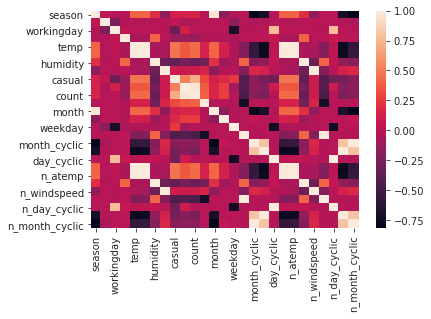

In [27]:
sns.heatmap(corr)

In [28]:
corr[['casual', 'registered', 'count']]

,casual,registered,count
season,0.128613,0.140322,0.152100
holiday,0.043037,-0.023111,-0.006934
workingday,-0.318093,0.120610,0.009814
weather,-0.130619,-0.113358,-0.130411
temp,0.474554,0.362248,0.432864
atemp,0.468035,0.356235,0.426062
humidity,-0.346825,-0.268988,-0.319857
windspeed,0.092607,0.086964,0.097903
casual,1.000000,0.513595,0.706012
registered,0.513595,1.000000,0.970263


The very first thing we observe is, casual riders are more likely to be affected by weather conditions. For example, correlation with casual bike renters count with temperature are higher than the correlation with registered bike renters count. Also, causal bikers seems to be more affected by humidity and weather situation.

Second thing we see is, casual users count is negatively correlated with working day. This might be because of the reason that casual users might be riding on weekends and holidays. And also, registered riders don't seem to be affected by working day that much.

Lastly, we see that the registered bike renters count is more affected by the hour than causal bike renters count. 

To sum up, there are differences in the relations of features with casual riders and registered riders. So, doing a two separate regression analysis with respect to both casual and registered, will give us a better insight. And of course, an additional regression analysis with total count will be done and compared with separate analyses done with casual and registered.

##### Distribution of the Features

Let us make some visualizations to better understand the distribution of the features in the dataset

In [29]:
df_hour.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'month', 'year', 'weekday', 'hour_cyclic', 'month_cyclic',
       'season_cyclic', 'day_cyclic'],
      dtype='object')

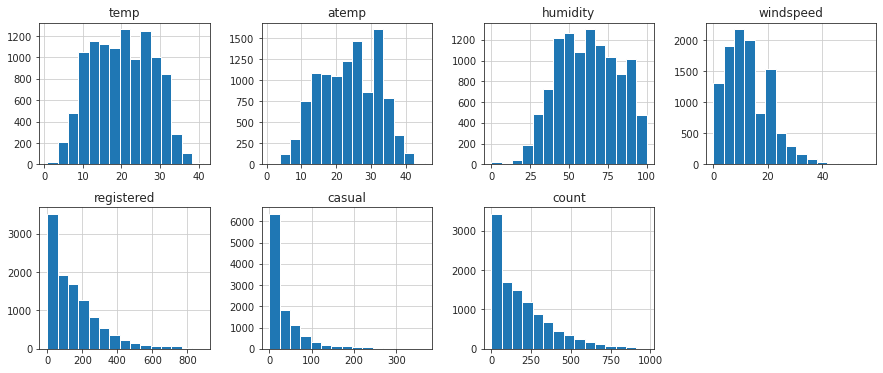

In [30]:
df_hour[numerical_features].hist(bins=15, figsize=(15, 6), layout=(2, 4));

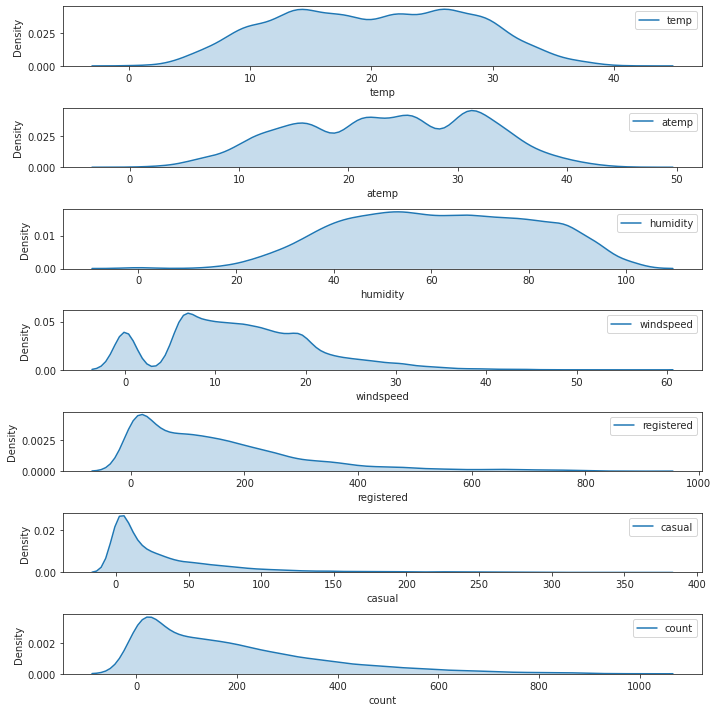

In [31]:
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(10,10))
for i, column in enumerate(numerical_features):
    sns.kdeplot(df_hour[column],ax=axes[i], shade=True).set(xlabel=column, ylabel='Density')

plt.tight_layout()

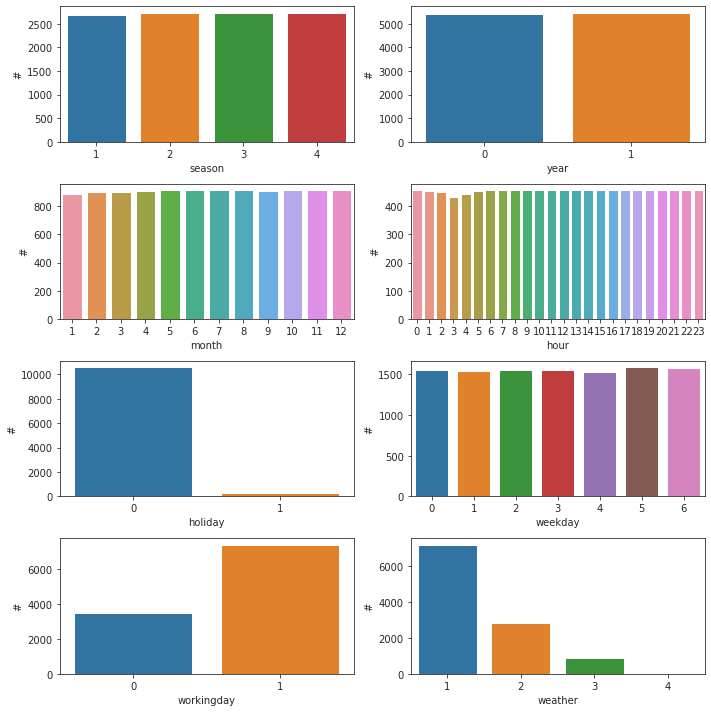

In [32]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10))
for i, column in enumerate(categorical_features):
    sns.countplot(df_hour[column],ax=axes[i//2, i%2]).set(xlabel=column, ylabel='#')

plt.tight_layout()

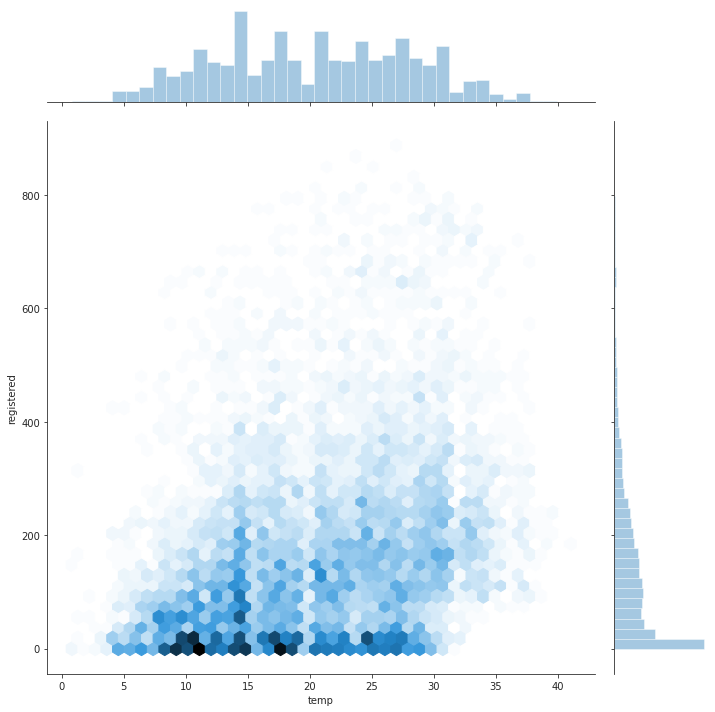

In [33]:
sns.jointplot(x='temp', y='registered', kind="hex", data=df_hour, height=10)

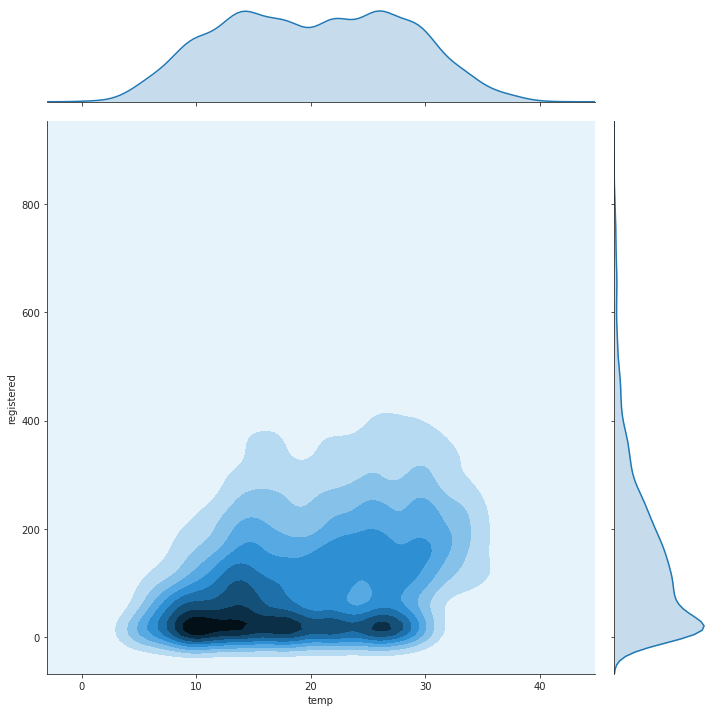

In [34]:
sns.jointplot(x='temp', y='registered', kind="kde", data=df_hour, height=10);

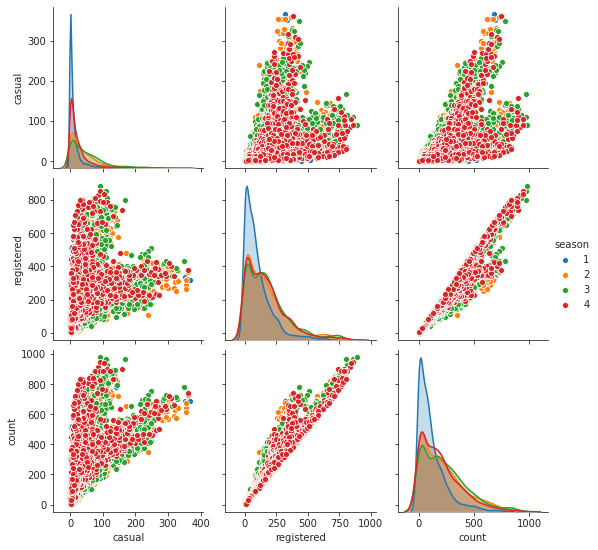

In [35]:
sns.pairplot(df_hour[['casual', 'registered', 'count', 'season']], hue='season')

Note: Most important thing we can observe is that distribution of our target variables (cnt, registered, casual) look very alike to the Poisson distribution. Poisson distribution is used to model the probability of count of an event occuring in a certain time interval.

In [47]:
train_reg_columns = ['season', 'holiday', 'workingday', 'n_temp', 'n_humidity', 'n_windspeed', 'hour', 'month', 'year', 'weekday']
train_cas_columns =  ['season', 'holiday', 'workingday', 'n_temp', 'n_humidity', 'n_windspeed', 'hour', 'month', 'year', 'weekday']

### Feature Selection

After having some ideas over our features, now we can apply feature selection to get rid of unnecessary features and build our model with the features that have the most influence on our targets.

In [48]:
X_train = df_train.drop(['registered', 'casual', 'count'], axis=1)
X_val = df_val.drop(['registered', 'casual', 'count'], axis=1)

y_train_reg = df_train['registered']
y_train_cas = df_train['casual']

y_val_reg = df_val['registered']
y_val_cas = df_val['casual']

y_train_cnt = df_train['count']
y_val_cnt = df_val['count']

X_train.shape, X_val.shape

((9777, 25), (1089, 25))

In [49]:
X_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour', 'month', 'year', 'weekday',
       'hour_cyclic', 'month_cyclic', 'season_cyclic', 'day_cyclic', 'n_temp',
       'n_atemp', 'n_humidity', 'n_windspeed', 'n_hour_cyclic', 'n_day_cyclic',
       'n_season_cyclic', 'n_month_cyclic'],
      dtype='object')

Now let's begin by removing hour, month, season and weekday because we replaced them with cyclic features. After that we will remove highly correlated features. Also, we'll remove temp, atemp, humidity and windspeed because we'll use standardized columns. And we'll remove datetime because we won't use it

In [50]:
feature_corr = X_train.corr()

In [51]:
feature_corr[feature_corr > 0.8]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,...,season_cyclic,day_cyclic,n_temp,n_atemp,n_humidity,n_windspeed,n_hour_cyclic,n_day_cyclic,n_season_cyclic,n_month_cyclic
season,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,NaN,NaN,NaN,NaN,1.000000,0.984419,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000000,0.984419,NaN,NaN,NaN,NaN,NaN,NaN
atemp,NaN,NaN,NaN,NaN,0.984419,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,0.984419,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
humidity,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
windspeed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.967076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As you can see, n_atemp and n_temp are almost perfectly correlated. Let's drop n_atemp. Also, let's drop season_cyclic because it is highly correlated with month_cyclic

In [52]:
X_train = X_train.drop(['n_atemp', 'n_month_cyclic'], axis=1)

We'll be using the Recursive Feature Elimination (RFE) method to select the best features. Specifically, we'll use RFECV from the sklearn. It automatically finds the best features by doing Cross Validation.

In [53]:
train_reg_columns = ['season', 'holiday', 'workingday', 'weather', 'n_temp', 'n_humidity', 'n_windspeed', 'hour', 'month', 'year', 'weekday']
train_cas_columns =  ['season', 'holiday', 'workingday', 'weather', 'n_temp', 'n_humidity', 'n_windspeed', 'hour', 'month', 'year', 'weekday']

In [54]:
X_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,...,hour_cyclic,month_cyclic,season_cyclic,day_cyclic,n_temp,n_humidity,n_windspeed,n_hour_cyclic,n_day_cyclic,n_season_cyclic
0,2011-05-19 22:00:00,2,0,1,3,20.50,24.240,82,19.9995,22,...,-0.269797,0.500000,1.224647e-16,0.433884,0.489796,0.82,0.350888,0.364786,0.722521,0.5
1,2012-01-09 09:00:00,1,0,1,2,9.02,13.635,64,0.0000,9,...,0.631088,0.500000,1.000000e+00,0.000000,0.204082,0.64,0.000000,0.816281,0.500000,1.0
2,2011-02-04 07:00:00,1,0,1,1,5.74,10.605,59,0.0000,7,...,0.942261,0.866025,1.000000e+00,-0.433884,0.122449,0.59,0.000000,0.972231,0.277479,1.0
3,2012-04-04 03:00:00,2,0,1,1,18.04,21.970,58,6.0032,3,...,0.730836,0.866025,1.224647e-16,0.974928,0.428571,0.58,0.105325,0.866272,1.000000,0.5
4,2012-10-08 03:00:00,4,1,0,1,13.94,17.425,81,7.0015,3,...,0.730836,-0.866025,-2.449294e-16,0.000000,0.326531,0.81,0.122840,0.866272,0.500000,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9792,2011-04-12 10:00:00,2,0,1,3,20.50,24.240,82,27.9993,10,...,0.398401,0.866025,1.224647e-16,0.781831,0.489796,0.82,0.491243,0.699666,0.900969,0.5
9793,2011-02-17 20:00:00,1,0,1,1,19.68,23.485,59,22.0028,20,...,-0.730836,0.866025,1.000000e+00,0.433884,0.469388,0.59,0.386035,0.133728,0.722521,1.0
9794,2012-07-17 14:00:00,3,0,1,1,38.54,41.665,29,16.9979,14,...,-0.631088,-0.500000,-1.000000e+00,0.781831,0.938776,0.29,0.298225,0.183719,0.900969,0.0
9795,2012-02-07 04:00:00,1,0,1,2,12.30,16.665,70,0.0000,4,...,0.887885,0.866025,1.000000e+00,0.781831,0.285714,0.70,0.000000,0.944980,0.900969,1.0


In [55]:
X_train_reg = X_train[train_reg_columns]
X_train_cas = X_train[train_cas_columns]

We'll do randomized search with XGBoost Regressor with the objective count:poisson as we discussed.

In [56]:
parameters = {
    'n_estimators': [150, 200, 300, 500, 700, 1000],
    'learning_rate': np.arange(0.05, 0.45, 0.05),
    'colsample_bylevel': np.arange(0.3, 0.9, 0.1),
    'max_depth': [10, 15],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1],
}
randomized_xgb_reg = RandomizedSearchCV(xgb.XGBRegressor(objective='count:poisson', gpu_id=0), parameters, n_iter=30)
randomized_xgb_reg.fit(X_train[train_reg_columns], y_train_reg)
randomized_xgb_reg.score(X_val[train_reg_columns], y_val_reg)

0.9147140792307434

In [57]:
randomized_xgb_reg.best_params_

{'n_estimators': 500,
 'max_depth': 10,
 'learning_rate': 0.2,
 'colsample_bytree': 1,
 'colsample_bylevel': 0.6000000000000001}

In [58]:
parameters = {
    'n_estimators': [1000, 1500, 2000],
    'learning_rate': np.arange(0.05, 0.45, 0.05),
    'colsample_bylevel': np.arange(0.3, 0.9, 0.1),
    'max_depth': [10, 15],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1],
}
randomized_xgb_cas = RandomizedSearchCV(xgb.XGBRegressor(objective='count:poisson'), parameters, n_iter=30)
randomized_xgb_cas.fit(X_train[train_cas_columns], y_train_cas)
randomized_xgb_cas.score(X_val[train_cas_columns], y_val_cas)

0.8403751677241873

In [59]:
randomized_xgb_cas.best_params_

{'n_estimators': 1500,
 'max_depth': 10,
 'learning_rate': 0.15000000000000002,
 'colsample_bytree': 1,
 'colsample_bylevel': 0.7000000000000002}

In [60]:
pred_reg = randomized_xgb_reg.predict(X_val[train_reg_columns])
pred_cas = randomized_xgb_cas.predict(X_val[train_cas_columns])

pred_reg[pred_reg < 0] = 0
pred_cas[pred_cas < 0] = 0

pred = pred_reg + pred_cas

Let's see the Root Mean Squared Log Error and R2 Score in validation set to evaluate our model.

In [62]:
np.sqrt(mean_squared_log_error(y_val_cnt, pred)), r2_score(y_val_cnt, pred)

(0.3530912604206149, 0.9053179447874337)